# RED NEURONAL PARA LA DETECCIÓN DE DADOS DAÑADOS

A01750202 | Abril Berenice Bautista Román<br>

#### LIBRERÍAS

In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import math

In [11]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.optimizers import  Adam, SGD, Adamax, Adadelta, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from keras.preprocessing import image
import matplotlib.pyplot as plt

### MUESTRAS DE ENTRENAMIENTO, PRUEBAS Y VALIDACIÓN

In [36]:
img_entrenamiento = 'entrenamiento'
img_prueba = 'prueba'
img_validacion_bueno = 'validacion_bueno'
img_validacion_malo = 'validacion_malo'

#### Eliminación de las imagenes no compatibles (JFIF, GIF)

In [38]:
import os

num_skipped = 0
for folder_name in ("bueno", "malo"):
    folder_path = os.path.join("entrenamiento", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


#### METADATOS DE ENTRENAMIENTO

In [39]:
ancho, altura = 80, 80
kernel1 = 32
kernel2 = 64
filtro_conv1 = (3,3)
filtro_conv2 = (2,2)
filtro_pooling = (2,2)
epocas = 50 #epochs
tamano_lote = 32 #batch (se acostumbra hacer en potencias de 2)
clases = 2
alfa = 0.0004 #learning rate

#### GENERACIÓN DE DATOS DE ENTRENAMIENTO, PRUEBA Y VALDIACIÓN

In [40]:
generacion_entrenamiento = ImageDataGenerator(rescale=1./255,
                                              shear_range=0.3,
                                              zoom_range=0.3,
                                              horizontal_flip=True)
generacion_prueba = ImageDataGenerator(rescale=1./255)

#generamos una base de datos de clasificación para entrenamiento
datos_entrenamiento = generacion_entrenamiento.flow_from_directory(img_entrenamiento,
                                                                   target_size=(altura, ancho),
                                                                   batch_size=tamano_lote,
                                                                   class_mode='categorical')
print(datos_entrenamiento.class_indices)

#generamos una base de datos de clasificación para prueba
datos_prueba = generacion_prueba.flow_from_directory(img_prueba,
                                                     target_size=(altura, ancho),
                                                     batch_size=tamano_lote,
                                                     class_mode='categorical')
print(datos_prueba.class_indices)

Found 1600 images belonging to 2 classes.
{'bueno': 0, 'malo': 1}
Found 248 images belonging to 2 classes.
{'bueno': 0, 'malo': 1}


In [41]:
generacion_validacion = ImageDataGenerator(preprocessing_function=preprocess_input)

#generamos una base de datos de prueba para gatos
datos_validacion_bueno = generacion_validacion.flow_from_directory(directory='validacion_bueno',
                                                                 target_size=(altura,ancho),
                                                                 color_mode='rgb',
                                                                 batch_size=1,
                                                                  class_mode=None)

print(datos_validacion_bueno.class_indices)

#generamos una base de datos de prueba para perros
datos_validacion_malo = generacion_validacion.flow_from_directory(img_validacion_malo,
                                                                   target_size=(altura,ancho),
                                                                   color_mode='rgb',
                                                                   batch_size=1,
                                                                  class_mode=None)
print(datos_validacion_malo.class_indices)

Found 10 images belonging to 1 classes.
{'bueno': 0}
Found 5 images belonging to 1 classes.
{'malo': 0}


### DISEÑO DE LA MORFOLOGÍA DE LA RED NEURONAL

In [42]:
modeloCNN = Sequential()

#Inicia Parte Convolucional
modeloCNN.add(Convolution2D(kernel1,
                            filtro_conv1,
                            padding="same",
                            input_shape=(altura,ancho,3),
                            activation='relu'))
modeloCNN.add(MaxPooling2D(pool_size=filtro_pooling)) #maximo de 2x2

modeloCNN.add(Convolution2D(kernel2,
                            filtro_conv2,
                            padding="same"))
modeloCNN.add(MaxPooling2D(pool_size=filtro_pooling))

modeloCNN.add(Flatten())
#Termina la parte convoucional

#empieza ANN 
modeloCNN.add(Dense(256,activation='relu'))
modeloCNN.add(Dense(clases,activation='softmax'))
modeloCNN.compile(loss='categorical_crossentropy', optimizer=Adamax(learning_rate=alfa), metrics=['accuracy'])

In [43]:
historical = modeloCNN.fit(datos_entrenamiento,epochs=epocas, batch_size=tamano_lote,validation_data=datos_prueba)

Epoch 1/50
50/50 [==============================] - 10s 199ms/step - loss: 0.8438 - accuracy: 0.5763 - val_loss: 0.7885 - val_accuracy: 0.3871
Epoch 2/50
50/50 [==============================] - 10s 202ms/step - loss: 0.5953 - accuracy: 0.7056 - val_loss: 0.7542 - val_accuracy: 0.4315
Epoch 3/50
50/50 [==============================] - 10s 196ms/step - loss: 0.5541 - accuracy: 0.7337 - val_loss: 0.7435 - val_accuracy: 0.5040
Epoch 4/50
50/50 [==============================] - 9s 187ms/step - loss: 0.5075 - accuracy: 0.7862 - val_loss: 0.7929 - val_accuracy: 0.4839
Epoch 5/50
50/50 [==============================] - 10s 192ms/step - loss: 0.5012 - accuracy: 0.7650 - val_loss: 0.8322 - val_accuracy: 0.4435
Epoch 6/50
50/50 [==============================] - 10s 198ms/step - loss: 0.4735 - accuracy: 0.7975 - val_loss: 0.8299 - val_accuracy: 0.4960
Epoch 7/50
50/50 [==============================] - 10s 198ms/step - loss: 0.4682 - accuracy: 0.7856 - val_loss: 0.8822 - val_accuracy: 0.4919


#### PREDICCIÓN DEL MODELO CON EL SET DE VALIDACIÓN

In [44]:
prediccion_bueno = modeloCNN.predict(datos_validacion_bueno)
prediccion_malo = modeloCNN.predict(datos_validacion_malo)

In [45]:
resultados_bueno = np.argmax(prediccion_bueno, axis = 1)
print ("Buenos: 0 - Malos: 1")
print(resultados_bueno)

resultados_malo = np.argmax(prediccion_malo, axis = 1)
#print(resultados_malo)

prediccion_total = np.concatenate((resultados_bueno, resultados_malo))

Buenos: 0 - Malos: 1
[0 0 0 1 0 0 0 1 0 1]


In [46]:
verdad_bueno = np.array([0]*10)
verdad_malo = np.array([1]*5)
verdad_total = np.concatenate((verdad_bueno, verdad_malo))

### MATRIZ DE CONFUSIÓN DE LA RED

In [47]:
from sklearn.metrics import confusion_matrix
matriz_confusion = confusion_matrix(prediccion_total,verdad_total)
print(matriz_confusion)

[[7 0]
 [3 5]]


### ANÁLISIS DEL FUNCIONAMIENTO DE LA RED NEURONAL

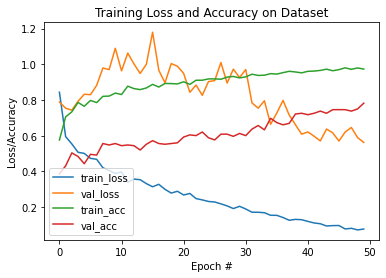

In [48]:
plt.figure()
N = np.arange(0, epocas)
plt.plot(N, historical.history["loss"], label="train_loss")
plt.plot(N, historical.history["val_loss"], label="val_loss")
plt.plot(N, historical.history["accuracy"], label="train_acc")
plt.plot(N, historical.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("results.png", dpi=300,bbox_inches='tight')
plt.show()

### EXPORTACIÓN DEL MODELO EN FORMATO H5

In [49]:
modeloCNN.save('modeloCNNreto.h5')

# PRUEBAS

In [7]:
import os
import cv2
import time
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import  Adamax

alfa = 0.0004 #learning rate

modelo = load_model('modeloCNNreto.h5')
modelo.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 80, 80, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 40, 40, 64)        8256      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 20, 20, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 25600)             0         
                                                                 
 dense_2 (Dense)             (None, 256)              

In [ ]:
modelo.compile(loss='categorical_crossentropy', optimizer=Adamax(learning_rate=alfa), metrics=['accuracy'])

test_path = "C:/Users/nancy/MATLAB Drive/computo_cognitivo/python-video-stream" #FROM SOCKET
while True:
    #print("reading...")
    
    file_name = "frame.jpg"
    
    image_path = test_path + "/" + file_name
    image = cv2.imread(image_path)
    
    if image is None:
        continue
    
    image = cv2.resize(image,(80,80))
    image = np.reshape(image,[1,80,80,3])

    classes = modelo.predict(image)
    print(classes)
    if np.argmax(classes) == 0:
        print("DADO EN BUEN ESTADO")
    else:
        print("¡¡ DADO EN MAL ESTADO !!")
        
    os.remove(image_path)